In [9]:
from typing import TypedDict

from langgraph.graph import add_messages
from typing_extensions import List, Annotated


class AgentState(TypedDict):
    messages: Annotated[List[str], add_messages]
    general_procedure: str
    steps: List[str]

E:\agenticai\venv\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [10]:
from langchain_ollama import ChatOllama

base_llm_model = ChatOllama(model="llama3.1:latest")

In [11]:
from pydantic import BaseModel, Field


class StepsStructuredOutput(BaseModel):
    steps: List[str] = Field(description="Small digestible steps required to complete the given task")


def convert_to_list(procedure) -> List[str]:
    system_prompt = SystemMessage("""
        You are given an input that contains steps to complete a particular task. You are to take that
        input text and convert it to a list of strings.
    """)
    user_prompt = HumanMessage(f"""
        Steps: {procedure}
    """)
    messages = [system_prompt, user_prompt]
    template = ChatPromptTemplate.from_messages(messages)

    structured_llm_model = base_llm_model.with_structured_output(StepsStructuredOutput)

    chain = template | structured_llm_model
    result = chain.invoke({})
    return result.steps


In [12]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate


def generate_required_steps(state: AgentState):
    system_prompt = SystemMessage("""
        You are a IT assistant. You job is to take the input question and respond with easily digestible
        steps required to complete the job
    """)
    user_prompt = HumanMessage(f"""
        Query: {state['messages']}
    """)
    messages = [system_prompt, user_prompt]
    template = ChatPromptTemplate.from_messages(messages)
    chain = template | base_llm_model
    result = chain.invoke({})
    print(result)
    returned_steps = convert_to_list(result.content)
    print(returned_steps)
    return {"messages": [result], "general_procedure": result.content, "steps": returned_steps}


In [13]:
from langgraph.types import Send


def orchestrator(state: AgentState):
    return [Send("worker", {"individual_step": step}) for step in state['steps']]

# def master(state: AgentState):
#     return [Send("worker",{"individual_step": step}) for step in state['steps'] ]

In [14]:
import time
from langchain_core.tools import tool

def file_writer(process:str):
    ts = time.time()
    with open("./debug.log", "a") as f:
        f.write(str(ts)+ f" => {process}\n")


@tool
def press_start_btn():
    """Presses the windows key on keyboard"""
    print("✅#####----Presses the windows key on keyboard---####")
    file_writer("press_start_btn")
    return "Pressed the windows key on keyboard"


@tool
def shutdown_laptop():
    """Clicks on the shut down button in the start menu"""
    print("✅#####---Click on the shut down button in the start menu---####")
    file_writer("shutdown_laptop")
    return "Clicked on the shut down button in the start menu"


tools = [press_start_btn, shutdown_laptop]
tools

[StructuredTool(name='press_start_btn', description='Presses the windows key on keyboard', args_schema=<class 'langchain_core.utils.pydantic.press_start_btn'>, func=<function press_start_btn at 0x0000012E85C7D900>),
 StructuredTool(name='shutdown_laptop', description='Clicks on the shut down button in the start menu', args_schema=<class 'langchain_core.utils.pydantic.shutdown_laptop'>, func=<function shutdown_laptop at 0x0000012E85C7DB40>)]

In [15]:

class WorkerState(TypedDict):
    individual_step: str


llm_with_tools = base_llm_model.bind_tools(tools)


def worker(worker_state: WorkerState):
    result = llm_with_tools.invoke(worker_state['individual_step'])
    return {"messages": [result]}

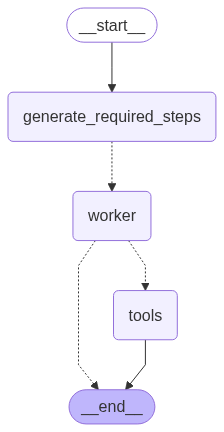

In [16]:
from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.constants import START
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

graph_builder.add_node("generate_required_steps", generate_required_steps)
# graph_builder.add_node("orchestrator", orchestrator)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_node("worker", worker)

graph_builder.add_edge(START, "generate_required_steps")
# graph_builder.add_edge("generate_required_steps", "worker")
graph_builder.add_conditional_edges("generate_required_steps", orchestrator, ["worker"])
graph_builder.add_conditional_edges("worker", tools_condition)
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()
graph


In [17]:
result=graph.invoke({"messages":"How to shut down a windows laptop"})
result

content='Here are the easily digestible steps to shut down a Windows laptop:\n\n**Step 1: Click on Start button**\n\n* Locate the Start button at the bottom left corner of your screen.\n* Click on it with your mouse.\n\n**Step 2: Select Power Options**\n\n* From the menu that appears, select "Power" or "Shut Down".\n* You can also type "shutdown" in the search bar and click on the result to access power options.\n\n**Step 3: Confirm Shutdown**\n\n* A prompt will appear asking if you\'re sure you want to shut down your laptop.\n* Click "Yes" or "OK" to confirm shutdown.\n\n**Alternative Method: Press Windows Key + X**\n\n* If you\'re in a hurry, you can also press the Windows key + X on your keyboard.\n* This will open a menu with power options. Select "Shut Down" or "Restart".\n\nThat\'s it! Your laptop should now shut down safely.' additional_kwargs={} response_metadata={'model': 'llama3.1:latest', 'created_at': '2025-06-18T15:34:33.0868032Z', 'done': True, 'done_reason': 'stop', 'tot

{'messages': [HumanMessage(content='How to shut down a windows laptop', additional_kwargs={}, response_metadata={}, id='e79807b6-f2fc-4214-9960-45a8b50286a3'),
  AIMessage(content='Here are the easily digestible steps to shut down a Windows laptop:\n\n**Step 1: Click on Start button**\n\n* Locate the Start button at the bottom left corner of your screen.\n* Click on it with your mouse.\n\n**Step 2: Select Power Options**\n\n* From the menu that appears, select "Power" or "Shut Down".\n* You can also type "shutdown" in the search bar and click on the result to access power options.\n\n**Step 3: Confirm Shutdown**\n\n* A prompt will appear asking if you\'re sure you want to shut down your laptop.\n* Click "Yes" or "OK" to confirm shutdown.\n\n**Alternative Method: Press Windows Key + X**\n\n* If you\'re in a hurry, you can also press the Windows key + X on your keyboard.\n* This will open a menu with power options. Select "Shut Down" or "Restart".\n\nThat\'s it! Your laptop should now sh

In [18]:
for i in result['messages']:
    i.pretty_print()

================================ Human Message =================================

How to shut down a windows laptop
================================== Ai Message ==================================

Here are the easily digestible steps to shut down a Windows laptop:

**Step 1: Click on Start button**

* Locate the Start button at the bottom left corner of your screen.
* Click on it with your mouse.

**Step 2: Select Power Options**

* From the menu that appears, select "Power" or "Shut Down".
* You can also type "shutdown" in the search bar and click on the result to access power options.

**Step 3: Confirm Shutdown**

* A prompt will appear asking if you're sure you want to shut down your laptop.
* Click "Yes" or "OK" to confirm shutdown.

**Alternative Method: Press Windows Key + X**

* If you're in a hurry, you can also press the Windows key + X on your keyboard.
* This will open a menu with power options. Select "Shut Down" or "Restart".

That's it! Your laptop should now shut down 

In [19]:
from IPython.display import Markdown
Markdown(result['general_procedure'])

Here are the easily digestible steps to shut down a Windows laptop:

**Step 1: Click on Start button**

* Locate the Start button at the bottom left corner of your screen.
* Click on it with your mouse.

**Step 2: Select Power Options**

* From the menu that appears, select "Power" or "Shut Down".
* You can also type "shutdown" in the search bar and click on the result to access power options.

**Step 3: Confirm Shutdown**

* A prompt will appear asking if you're sure you want to shut down your laptop.
* Click "Yes" or "OK" to confirm shutdown.

**Alternative Method: Press Windows Key + X**

* If you're in a hurry, you can also press the Windows key + X on your keyboard.
* This will open a menu with power options. Select "Shut Down" or "Restart".

That's it! Your laptop should now shut down safely.